# Python: Impact of 401(k) on Financial Wealth

In this real-data example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the effect of 401(k) eligibility and participation on accumulated assets. The 401(k) data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060).

401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

## Data

The preprocessed data can be fetched by calling [fetch_401K()](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.fetch_401K.html#doubleml.datasets.fetch_401K). Note that an internet connection is required for loading the data.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
colors = sns.color_palette()

In [3]:
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

In [4]:
data = fetch_401K(return_type='DataFrame')

In [5]:
# Temporary fix for https://github.com/DoubleML/doubleml-docs/issues/45 / https://github.com/scikit-learn/scikit-learn/issues/21997
# Can be removed when scikit-learn version 1.2.0 is released
dtypes = data.dtypes
dtypes['nifa'] = 'float64'
dtypes['net_tfa'] = 'float64'
dtypes['tw'] = 'float64'
dtypes['inc'] = 'float64'
data = data.astype(dtypes)

In [6]:
data.head()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1


In [7]:
data.describe()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
count,9.915000e+03,9.915000e+03,9.915000e+03,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,1.392864e+04,1.805153e+04,6.381685e+04,41.060212,37200.623197,2.865860,13.206253,0.271004,0.604841,0.380837,0.371357,0.261624,0.242158,0.635199
std,5.490488e+04,6.352250e+04,1.115297e+05,10.344505,24774.288006,1.538937,2.810382,0.444500,0.488909,0.485617,0.483192,0.439541,0.428411,0.481399
min,0.000000e+00,-5.023020e+05,-5.023020e+05,25.000000,-2652.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+02,-5.000000e+02,3.291500e+03,32.000000,19413.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.635000e+03,1.499000e+03,2.510000e+04,40.000000,31476.000000,3.000000,12.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,8.765500e+03,1.652450e+04,8.148750e+04,48.000000,48583.500000,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.430298e+06,1.536798e+06,2.029910e+06,64.000000,242124.000000,13.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

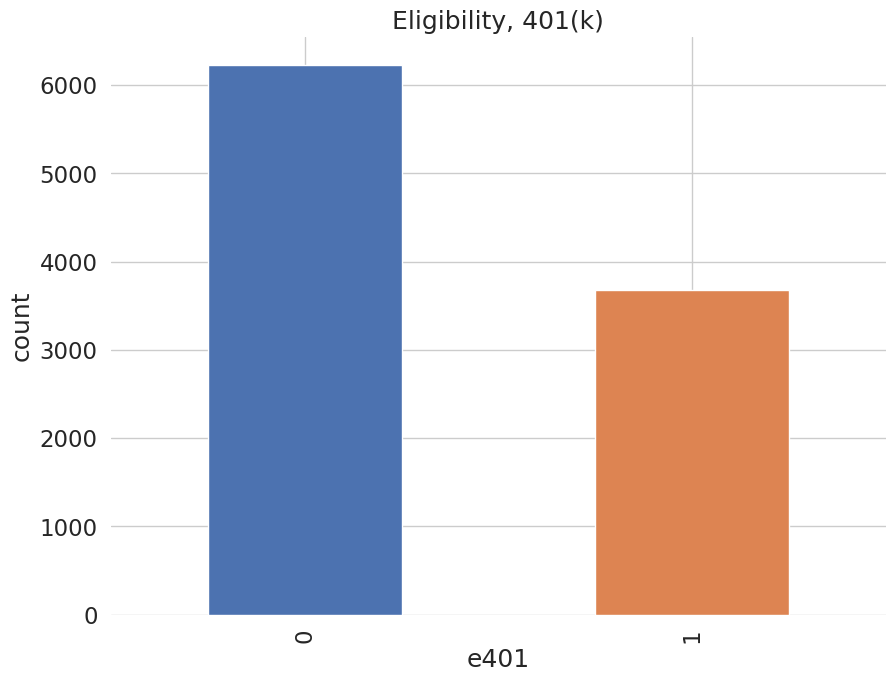

In [8]:
data['e401'].value_counts().plot(kind='bar', color=colors)
plt.title('Eligibility, 401(k)')
plt.xlabel('e401')
_ = plt.ylabel('count')

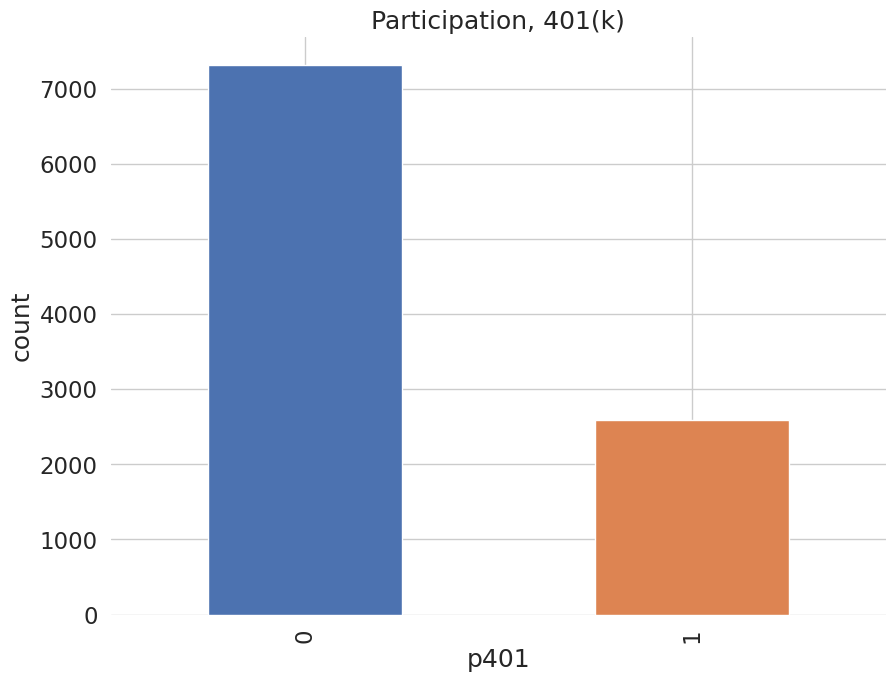

In [9]:
data['p401'].value_counts().plot(kind='bar', color=colors)
plt.title('Participation, 401(k)')
plt.xlabel('p401')
_ = plt.ylabel('count')

Eligibility is highly associated with financial wealth:

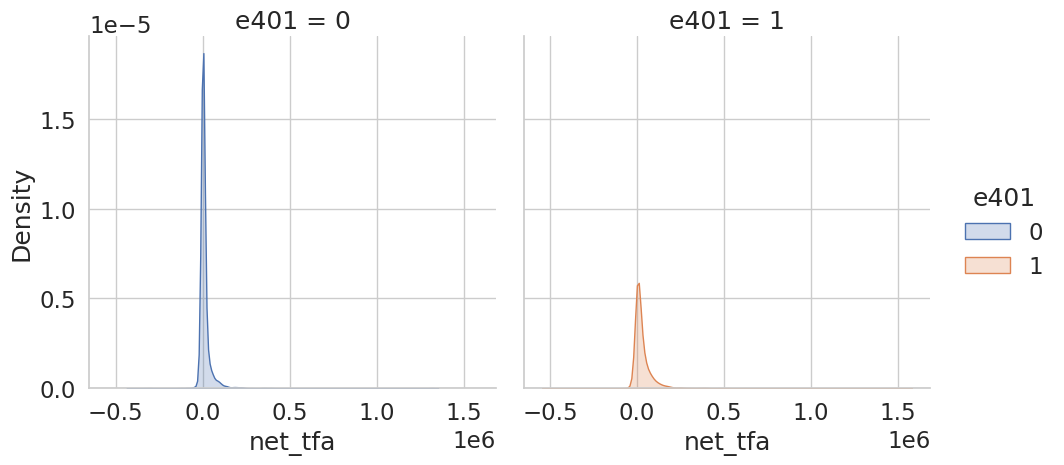

In [10]:
_ = sns.displot(data, x="net_tfa", hue="e401", col="e401",
                kind="kde", fill=True)

As a first estimate, we calculate the unconditional average predictive effect (APE) of 401(k) eligibility on accumulated assets. This effect corresponds to the average treatment effect if 401(k) eligibility would be assigned to individuals in an entirely randomized way. The unconditional APE of e401 is about $19559$:

In [11]:
data[['e401', 'net_tfa']].groupby('e401').mean().diff()

,net_tfa
e401,
0,NaN
1,19559.34475


Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [12]:
data[['p401', 'net_tfa']].groupby('p401').mean().diff()

,net_tfa
p401,
0,NaN
1,27371.583404


As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

## The `DoubleML` package

Let's use the package [DoubleML](https://docs.doubleml.org/stable/index.html) to estimate the average treatment effect of 401(k) eligibility, i.e. `e401`, and participation, i.e. `p401`, on net financial assets `net_tfa`.

## Estimating the Average Treatment Effect of 401(k) Eligibility on Net Financial Assets

We first look at the treatment effect of `e401` on net total financial assets. We give estimates of the ATE in the linear model

\begin{equation*}
Y = D \alpha + f(X)'\beta+ \epsilon,
\end{equation*}
where $f(X)$ is a dictonary applied to the raw regressors. $X$ contains variables on marital status, two-earner status, defined benefit pension status, IRA participation, home ownership, family size, education, age, and income. 

In the following, we will consider two different models, 

* a basic model specification that includes the raw regressors, i.e., $f(X) = X$, and 

* a flexible model specification, where $f(X)$ includes the raw regressors $X$ and the orthogonal polynomials of degree 2 for the variables family size education, age, and income. 

We will use the basic model specification whenever we use nonlinear methods, for example regression trees or random forests, and use the flexible model for linear methods such as the lasso. There are, of course, multiple ways how the model can be specified even more flexibly, for example including interactions of variable and higher order interaction. However, for the sake of simplicity we stick to the specification above. Users who are interested in varying the model can adapt the code below accordingly, for example to implement the orignal specification in [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060). 

In the first step, we report estimates of the average treatment effect (ATE) of 401(k) eligibility on net financial assets both in the partially linear regression (PLR) model and in the interactive regression model (IRM) allowing for heterogeneous treatment effects.

### The Data Backend: `DoubleMLData`

To start our analysis, we initialize the data backend, i.e., a new instance of a [DoubleMLData](https://docs.doubleml.org/dev/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) object. We implement the regression model by using scikit-learn's `PolynomialFeatures` class.

To implement both models (basic and flexible), we generate two data backends: `data_dml_base` and `data_dml_flex`.

In [13]:
# Set up basic model: Specify variables for data-backend
features_base = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown']

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = dml.DoubleMLData(data,
                                 y_col='net_tfa',
                                 d_cols='e401',
                                 x_cols=features_base)

In [14]:
print(data_dml_base)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float64(4), int8(10)
memory usage: 406.8 KB



In [15]:
# Set up a model according to regression formula with polynomials
features = data.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]

poly_dict = {'age': 2,
             'inc': 2,
             'educ': 2,
             'fsize': 2}
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_transf = poly.fit_transform(data[[key]])
    x_cols = poly.get_feature_names_out([key])
    data_transf = pd.DataFrame(data_transf, columns=x_cols)
    
    features = pd.concat((features, data_transf),
                          axis=1, sort=False)
model_data = pd.concat((data.copy()[['net_tfa', 'e401']], features.copy()),
                        axis=1, sort=False)

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_flex = dml.DoubleMLData(model_data, y_col='net_tfa', d_cols='e401')

In [16]:
print(data_dml_flex)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['marr', 'twoearn', 'db', 'pira', 'hown', 'age', 'age^2', 'inc', 'inc^2', 'educ', 'educ^2', 'fsize', 'fsize^2']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 15 entries, net_tfa to fsize^2
dtypes: float64(9), int8(6)
memory usage: 755.4 KB



### Partially Linear Regression Model (PLR)

We start using lasso to estimate the function $g_0$ and $m_0$ in the following PLR model:

\begin{eqnarray}
& Y = D\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid D,X]= 0,\\
& D = m_0(X) +  V, &\quad E[V \mid X] = 0.
\end{eqnarray}

To estimate the causal parameter $\theta_0$ here, we use double machine learning with 3-fold cross-fitting. 
 
Estimation of the nuisance components $g_0$ and $m_0$, is based on the lasso with cross-validated choice of the penalty term , $\lambda$, as provided by [scikit-learn](https://scikit-learn.org). We load the learner by initializing instances from the classes [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) and [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Hyperparameters and options can be set during instantiation of the learner. Here we specify that the lasso should use that value of $\lambda$ that minimizes the cross-validated mean squared error which is based on 5-fold cross validation.

We start by estimation the ATE in the basic model and then repeat the estimation in the flexible model.

In [17]:
# Initialize learners
Cs = 0.0001*np.logspace(0, 4, 10)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000))
lasso_class = make_pipeline(StandardScaler(),
                            LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear',
                                                 Cs = Cs, max_iter=1000))

np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr_lasso = dml.DoubleMLPLR(data_dml_base,
                                ml_l = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)

dml_plr_lasso.fit(store_predictions=True)
dml_plr_lasso.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,5722.474846,1380.619177,4.144861,0.000034,3016.510982,8428.438709


In [18]:
# Estimate the ATE in the flexible model with lasso

np.random.seed(123)
dml_plr_lasso = dml.DoubleMLPLR(data_dml_flex,
                                ml_l = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)

dml_plr_lasso.fit(store_predictions=True)
lasso_summary = dml_plr_lasso.summary

lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8974.79122,1324.323622,6.776887,1.227931e-11,6379.164617,11570.417822


Alternatively, we can repeat this procedure with other machine learning methods, for example a random forest learner as provided by the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class in [scikit-learn](https://scikit-learn.org). 

In [19]:
# Random Forest
randomForest = RandomForestRegressor(
    n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(
    n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml_base,
                                 ml_l = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)
dml_plr_forest.fit(store_predictions=True)
forest_summary = dml_plr_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8909.634078,1321.822289,6.740417,1.579322e-11,6318.909997,11500.358158


Now, let's use a regression tree as provided in [scikit-learn](https://scikit-learn.org)'s [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [20]:
# Trees
trees = DecisionTreeRegressor(
    max_depth=30, ccp_alpha=0.0047, min_samples_split=203, min_samples_leaf=67)
trees_class = DecisionTreeClassifier(
    max_depth=30, ccp_alpha=0.0042, min_samples_split=104, min_samples_leaf=34)

np.random.seed(123)
dml_plr_tree = dml.DoubleMLPLR(data_dml_base,
                               ml_l = trees,
                               ml_m = trees_class,
                               n_folds = 3)
dml_plr_tree.fit(store_predictions=True)
tree_summary = dml_plr_tree.summary

tree_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8260.06428,1348.624798,6.124805,9.079458e-10,5616.808246,10903.320314


We can also experiment with extreme gradient boosting as provided by [xgboost](https://xgboost.readthedocs.io/en/latest/).

In [21]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss",
                            eta=0.1, n_estimators=34)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_plr_boost.fit(store_predictions=True)
boost_summary = dml_plr_boost.summary

boost_summary

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8816.895718,1417.488973,6.220081,4.968994e-10,6038.668383,11595.123054


Let's sum up the results:

In [22]:
plr_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
plr_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
plr_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
lasso,8974.791220,6379.164617,11570.417822
forest,8909.634078,6318.909997,11500.358158
tree,8260.064280,5616.808246,10903.320314
xgboost,8816.895718,6038.668383,11595.123054


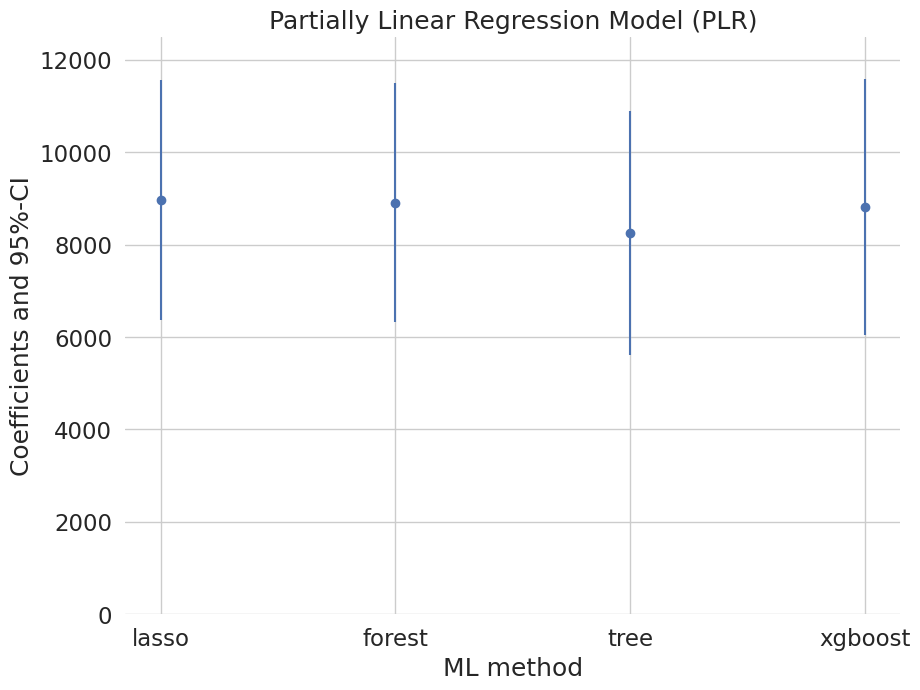

In [23]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 12500])

plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

### Interactive Regression Model (IRM)

Next, we consider estimation of average treatment effects when treatment effects are fully heterogeneous:

\begin{eqnarray}
& Y = g_0(D,X) + U, &\quad E[U\mid X,D] = 0,\\
& D = m_0(X) + V, &\quad E[V\mid X] = 0.
\end{eqnarray}

To reduce the disproportionate impact of extreme propensity score weights in the interactive model
we trim the propensity scores which are close to the bounds.

In [24]:
# Lasso
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))

# Initialize DoubleMLIRM model
np.random.seed(123)
dml_irm_lasso = dml.DoubleMLIRM(data_dml_flex,
                          ml_g = lasso,
                          ml_m = lasso_class,
                          trimming_threshold = 0.01,
                          n_folds = 3)
dml_irm_lasso.fit(store_predictions=True) 
lasso_summary = dml_irm_lasso.summary

lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,7918.27028,1206.438355,6.563344,5.261418e-11,5553.694555,10282.846006


In [25]:
# Random Forest
randomForest = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)
dml_irm_forest = dml.DoubleMLIRM(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 trimming_threshold = 0.01,
                                 n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_forest.set_ml_nuisance_params('ml_g0', 'e401', {
    'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 7})
dml_irm_forest.set_ml_nuisance_params('ml_g1', 'e401', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 5})
dml_irm_forest.set_ml_nuisance_params('ml_m', 'e401', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 6})

dml_irm_forest.fit(store_predictions=True) 
forest_summary = dml_irm_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8020.190199,1140.240133,7.033773,2.010222e-12,5785.360605,10255.019793


In [26]:
# Trees
trees = DecisionTreeRegressor(max_depth=30)
trees_class = DecisionTreeClassifier(max_depth=30)

np.random.seed(123)
dml_irm_tree = dml.DoubleMLIRM(data_dml_base,
                               ml_g = trees,
                               ml_m = trees_class,
                               trimming_threshold = 0.01,
                               n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_tree.set_ml_nuisance_params('ml_g0', 'e401', {
    'ccp_alpha': 0.0016, 'min_samples_split': 74, 'min_samples_leaf': 24})
dml_irm_tree.set_ml_nuisance_params('ml_g1', 'e401', {
    'ccp_alpha': 0.0018, 'min_samples_split': 70, 'min_samples_leaf': 23})
dml_irm_tree.set_ml_nuisance_params('ml_m', 'e401', {
    'ccp_alpha': 0.0028, 'min_samples_split': 167, 'min_samples_leaf': 55})

dml_irm_tree.fit(store_predictions=True)
tree_summary = dml_irm_tree.summary

tree_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8054.077008,1184.437455,6.799918,1.046791e-11,5732.622255,10375.531761


In [27]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror")
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

np.random.seed(123)
dml_irm_boost = dml.DoubleMLIRM(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                trimming_threshold = 0.01,
                                n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_boost.set_ml_nuisance_params('ml_g0', 'e401', {
    'eta': 0.1, 'n_estimators': 8})
dml_irm_boost.set_ml_nuisance_params('ml_g1', 'e401', {
    'eta': 0.1, 'n_estimators': 29})
dml_irm_boost.set_ml_nuisance_params('ml_m', 'e401', {
    'eta': 0.1, 'n_estimators': 23})

dml_irm_boost.fit(store_predictions=True)
boost_summary = dml_irm_boost.summary

boost_summary

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8232.06866,1231.951289,6.682138,2.354809e-11,5817.488503,10646.648817


In [28]:
irm_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
irm_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
irm_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
lasso,7918.270280,5553.694555,10282.846006
forest,8020.190199,5785.360605,10255.019793
tree,8054.077008,5732.622255,10375.531761
xgboost,8232.068660,5817.488503,10646.648817


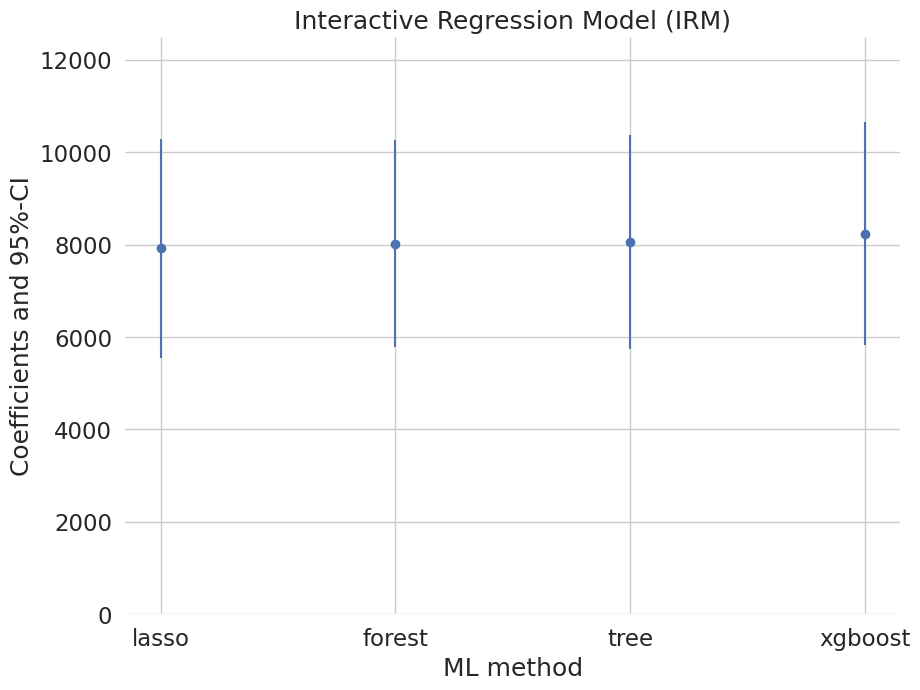

In [29]:
errors = np.full((2, irm_summary.shape[0]), np.nan)
errors[0, :] = irm_summary['coef'] - irm_summary['2.5 %']
errors[1, :] = irm_summary['97.5 %'] - irm_summary['coef']
plt.errorbar(irm_summary.index, irm_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 12500])

plt.title('Interactive Regression Model (IRM)')
plt.xlabel('ML method')
_ = plt.ylabel('Coefficients and 95%-CI')

These estimates that flexibly account for confounding are
substantially attenuated relative to the baseline estimate (*19559*) that does not account for confounding. They suggest much smaller causal effects of 401(k) eligiblity on financial asset holdings.

## Local Average Treatment Effects of 401(k) Participation on Net Financial Assets

### Interactive IV Model (IIVM)

In the examples above, we estimated the average treatment effect of *eligibility* on financial asset holdings. Now, we consider estimation of local average treatment effects (LATE) of *participation* using eligibility as an instrument for the participation decision. Under appropriate assumptions, the LATE identifies the treatment effect for so-called compliers, i.e., individuals who would only participate if eligible and otherwise not participate in the program. 

As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates. We use `e401` as a binary instrument for the treatment variable `p401`. Here the structural equation model is:

\begin{eqnarray}
& Y = g_0(Z,X) + U, &\quad E[U\mid Z,X] = 0,\\
& D = r_0(Z,X) + V, &\quad E[V\mid Z, X] = 0,\\
& Z = m_0(X) + \zeta, &\quad E[\zeta \mid X] = 0.
\end{eqnarray}

In [30]:
# Initialize DoubleMLData with an instrument

# Basic model
data_dml_base_iv = dml.DoubleMLData(data,
                                    y_col='net_tfa',
                                    d_cols='p401',
                                    z_cols='e401',
                                    x_cols=features_base)

print(data_dml_base_iv)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['p401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): ['e401']
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float64(4), int8(10)
memory usage: 406.8 KB



In [31]:
# Flexible model
model_data = pd.concat((data.copy()[['net_tfa', 'e401', 'p401']], features.copy()),
                        axis=1, sort=False)

data_dml_iv_flex = dml.DoubleMLData(model_data,
                                    y_col='net_tfa',
                                    d_cols='p401',
                                    z_cols='e401')

print(data_dml_iv_flex)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['p401']
Covariates: ['marr', 'twoearn', 'db', 'pira', 'hown', 'age', 'age^2', 'inc', 'inc^2', 'educ', 'educ^2', 'fsize', 'fsize^2']
Instrument variable(s): ['e401']
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 16 entries, net_tfa to fsize^2
dtypes: float64(9), int8(7)
memory usage: 765.1 KB



In [32]:
# Lasso
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))

# Initialize DoubleMLIRM model
np.random.seed(123)
dml_iivm_lasso = dml.DoubleMLIIVM(data_dml_iv_flex,
                                  ml_g = lasso,
                                  ml_m = lasso_class,
                                  ml_r = lasso_class,
                                  subgroups = {'always_takers': False,
                                             'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)
dml_iivm_lasso.fit(store_predictions=True)
lasso_summary = dml_iivm_lasso.summary

lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
p401,11489.25238,1747.417737,6.574989,4.865677e-11,8064.37655,14914.12821


Again, we repeat the procedure for the other machine learning methods:

In [33]:
# Random Forest
randomForest = RandomForestRegressor(n_estimators=500)
randomForest_class = RandomForestClassifier(n_estimators=500)

np.random.seed(123)
dml_iivm_forest = dml.DoubleMLIIVM(data_dml_base_iv,
                                   ml_g = randomForest,
                                   ml_m = randomForest_class,
                                   ml_r = randomForest_class,
                                   subgroups = {'always_takers': False,
                                                'never_takers': True},
                                   trimming_threshold = 0.01,
                                   n_folds = 3)

# Set nuisance-part specific parameters
dml_iivm_forest.set_ml_nuisance_params('ml_g0', 'p401', {
    'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 7})
dml_iivm_forest.set_ml_nuisance_params('ml_g1', 'p401', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 5})
dml_iivm_forest.set_ml_nuisance_params('ml_m', 'p401', {
    'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 6})
dml_iivm_forest.set_ml_nuisance_params('ml_r1', 'p401', {
    'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 6})

dml_iivm_forest.fit(store_predictions=True) 
forest_summary = dml_iivm_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
p401,11550.03435,1638.022642,7.051206,1.773742e-12,8339.568966,14760.499734


In [34]:
# Trees
trees = DecisionTreeRegressor(max_depth=30)
trees_class = DecisionTreeClassifier(max_depth=30)

np.random.seed(123)
dml_iivm_tree = dml.DoubleMLIIVM(data_dml_base_iv,
                                 ml_g = trees,
                                 ml_m = trees_class,
                                 ml_r = trees_class,
                                 subgroups = {'always_takers': False,
                                              'never_takers': True},
                                 trimming_threshold = 0.01,
                                 n_folds = 3)

# Set nuisance-part specific parameters
dml_iivm_tree.set_ml_nuisance_params('ml_g0', 'p401', {
    'ccp_alpha': 0.0016, 'min_samples_split': 74, 'min_samples_leaf': 24})
dml_iivm_tree.set_ml_nuisance_params('ml_g1', 'p401', {
    'ccp_alpha': 0.0018, 'min_samples_split': 70, 'min_samples_leaf': 23})
dml_iivm_tree.set_ml_nuisance_params('ml_m', 'p401', {
    'ccp_alpha': 0.0028, 'min_samples_split': 167, 'min_samples_leaf': 55})
dml_iivm_tree.set_ml_nuisance_params('ml_r1', 'p401', {
    'ccp_alpha': 0.0576, 'min_samples_split': 55, 'min_samples_leaf': 18})

dml_iivm_tree.fit(store_predictions=True)
tree_summary = dml_iivm_tree.summary

tree_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
p401,11512.640404,1689.239802,6.815279,9.408106e-12,8201.79123,14823.489578


In [35]:
# Boosted Trees
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror")
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

np.random.seed(123)
dml_iivm_boost = dml.DoubleMLIIVM(data_dml_base_iv,
                                  ml_g = boost,
                                  ml_m = boost_class,
                                  ml_r = boost_class,
                                  subgroups = {'always_takers': False,
                                               'never_takers': True},
                                  trimming_threshold = 0.01,
                                  n_folds = 3)

# Set nuisance-part specific parameters
dml_iivm_boost.set_ml_nuisance_params('ml_g0', 'p401', {
    'eta': 0.1, 'n_estimators': 9})
dml_iivm_boost.set_ml_nuisance_params('ml_g1', 'p401', {
    'eta': 0.1, 'n_estimators': 33})
dml_iivm_boost.set_ml_nuisance_params('ml_m', 'p401', {
    'eta': 0.1, 'n_estimators': 12})
dml_iivm_boost.set_ml_nuisance_params('ml_r1', 'p401', {
    'eta': 0.1, 'n_estimators': 25})

dml_iivm_boost.fit(store_predictions=True)
boost_summary = dml_iivm_boost.summary

boost_summary

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,coef,std err,t,P>|t|,2.5 %,97.5 %
p401,12412.530104,1678.83551,7.393536,1.429752e-13,9122.072968,15702.987241


In [36]:
iivm_summary = pd.concat((lasso_summary, forest_summary, tree_summary, boost_summary))
iivm_summary.index = ['lasso', 'forest', 'tree', 'xgboost']
iivm_summary[['coef', '2.5 %', '97.5 %']]

,coef,2.5 %,97.5 %
lasso,11489.252380,8064.376550,14914.128210
forest,11550.034350,8339.568966,14760.499734
tree,11512.640404,8201.791230,14823.489578
xgboost,12412.530104,9122.072968,15702.987241


In [37]:
colors = sns.color_palette()

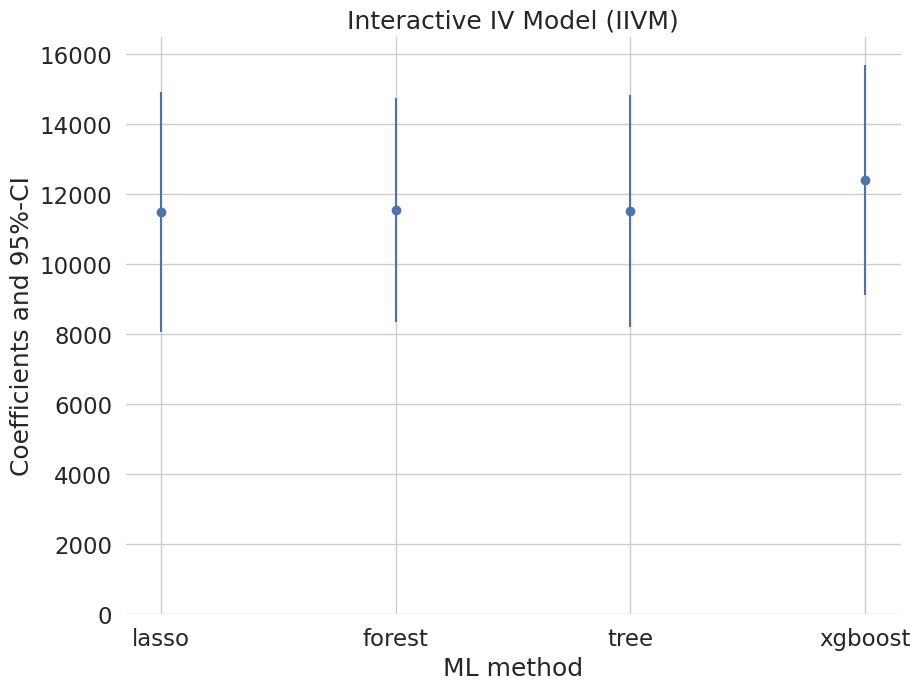

In [38]:
errors = np.full((2, iivm_summary.shape[0]), np.nan)
errors[0, :] = iivm_summary['coef'] - iivm_summary['2.5 %']
errors[1, :] = iivm_summary['97.5 %'] - iivm_summary['coef']
plt.errorbar(iivm_summary.index, iivm_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 16500])

plt.title('Interactive IV Model (IIVM)')
plt.xlabel('ML method')
_ = plt.ylabel('Coefficients and 95%-CI')

## Summary of Results

To sum up, let's merge all our results so far and illustrate them in a plot. 

In [39]:
df_summary = pd.concat((plr_summary, irm_summary, iivm_summary)).reset_index().rename(columns={'index': 'ML'})
df_summary['Model'] = np.concatenate((np.repeat('PLR', 4), np.repeat('IRM', 4), np.repeat('IIVM', 4)))
df_summary.set_index(['Model', 'ML'])

coef      std err         t         P>|t|        2.5 %   
Model ML                                                                        
PLR   lasso     8974.791220  1324.323622  6.776887  1.227931e-11  6379.164617  \
      forest    8909.634078  1321.822289  6.740417  1.579322e-11  6318.909997   
      tree      8260.064280  1348.624798  6.124805  9.079458e-10  5616.808246   
      xgboost   8816.895718  1417.488973  6.220081  4.968994e-10  6038.668383   
IRM   lasso     7918.270280  1206.438355  6.563344  5.261418e-11  5553.694555   
      forest    8020.190199  1140.240133  7.033773  2.010222e-12  5785.360605   
      tree      8054.077008  1184.437455  6.799918  1.046791e-11  5732.622255   
      xgboost   8232.068660  1231.951289  6.682138  2.354809e-11  5817.488503   
IIVM  lasso    11489.252380  1747.417737  6.574989  4.865677e-11  8064.376550   
      forest   11550.034350  1638.022642  7.051206  1.773742e-12  8339.568966   
      tree     11512.640404  1689.239802  6.815279  9.408106e-12  8201.791230   
      xgboost  12412.530104  1678.835510  7.393536  1.429752e-13  9122.072968   

                     97.5 %  
Model ML                     
PLR   lasso    11570.417822  
      forest   11500.358158  
      tree     10903.320314  
      xgboost  11595.123054  
IRM   lasso    10282.846006  
      forest   10255.019793  
      tree     10375.531761  
      xgboost  10646.648817  
IIVM  lasso    14914.128210  
      forest   14760.499734  
      tree     14823.489578  
      xgboost  15702.987241

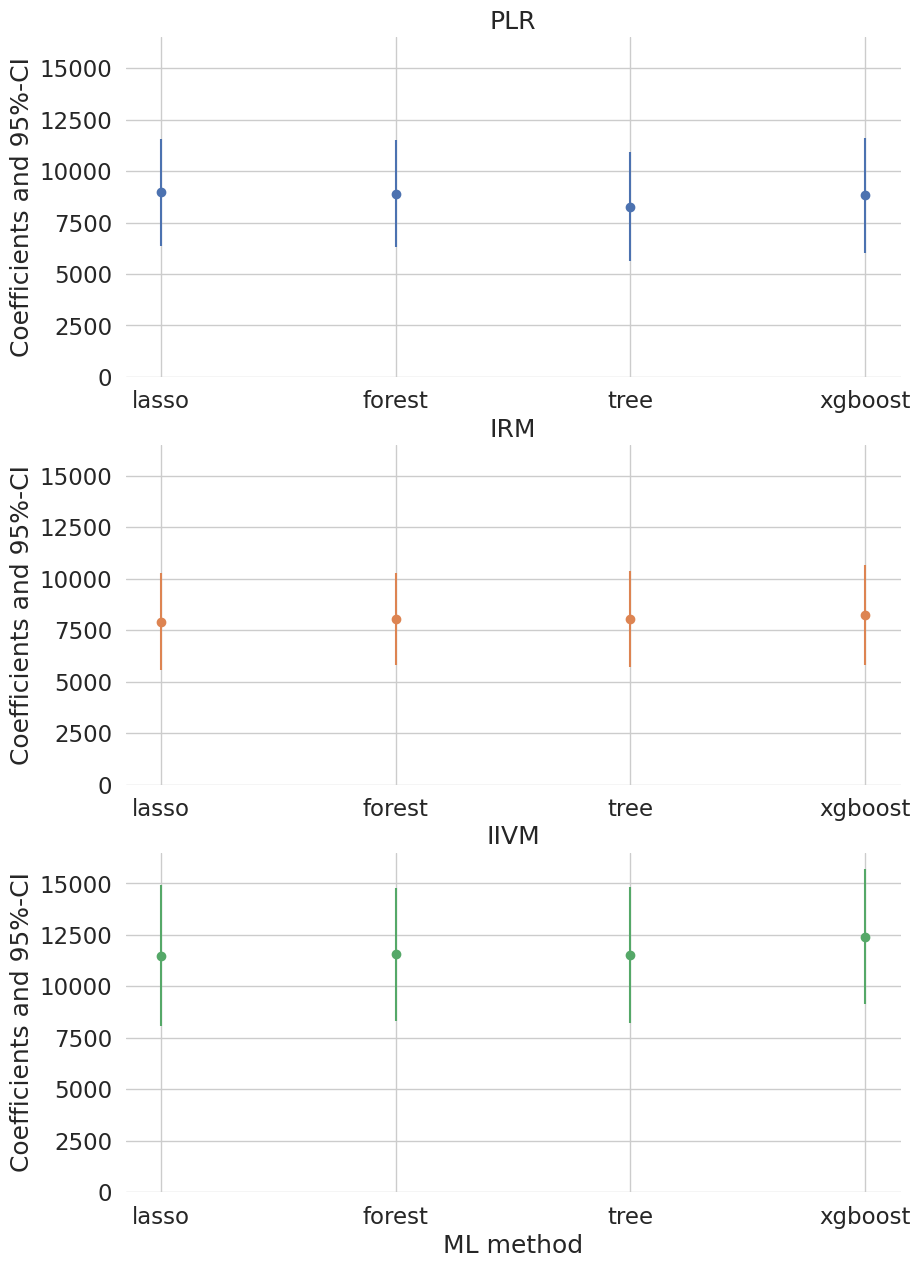

In [40]:
plt.figure(figsize=(10, 15))
colors = sns.color_palette()
for ind, model in enumerate(['PLR', 'IRM', 'IIVM']):
    plt.subplot(3, 1, ind+1)
    this_df = df_summary.query('Model == @model')
    errors = np.full((2, this_df.shape[0]), np.nan)
    errors[0, :] = this_df['coef'] - this_df['2.5 %']
    errors[1, :] = this_df['97.5 %'] - this_df['coef']
    plt.errorbar(this_df.ML, this_df.coef, fmt='o', yerr=errors,
                 color=colors[ind], ecolor=colors[ind])
    plt.ylim([0, 16500])
    plt.title(model)
    plt.ylabel('Coefficients and 95%-CI')

_ = plt.xlabel('ML method')

We report results based on four ML methods for estimating the nuisance functions used in
forming the orthogonal estimating equations. We find again that the estimates of the treatment effect are stable across ML methods. The estimates are highly significant, hence we would reject the hypothesis
that 401(k) participation has no effect on financial wealth.

______

**Acknowledgement**

We would like to thank [Jannis Kueck](https://www.bwl.uni-hamburg.de/en/statistik/team/kueck.html) for sharing [the kaggle notebook](https://www.kaggle.com/janniskueck/pm5-401k). The pension data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060).

